# Systemy inspekcji wizualnej  
## Laboratorium  5
 
Temat: Detekcja ruchu

Instrukcję opracował: dr inż. Łukasz Jeleń  
  
Wrocław 2022

---

Nazwisko i Imię: Jakub Grelowski  
Nr albumu: 262754  
data wykonania ćwiczenia: 26.11.2024  

---

# 1. Narzędzia  
  
  
Na zjęciach korzystamy z pythnona, a jako środowisko pracy mają Państwo do wyboru Google Colab (https://colab.research.google.com) - wersja online, lub Anaconda Navigator (https://www.anaconda.com/) - wymaga instalacji na własnym komputerze. Są to oczywiście tylko propozycje. 

# 2. Zadania. 
  
## Zadanie 1 - Detekcja zmian w obrazie (odejmowanie zdjęć) 
  
Na wyładzie poświęcownym operacjom na orazach mówiliśmy, że poprzez wyznaczenie różnicy między dwoma obrazami (`cv2.absdiff(src1,src2)`) możemy sprawdzić, czy obiekty na obrazach uległy zmianie.  
  
Do wykonania tego zadania proszę wykorzystać zdjęcia zamieszczone na e-portalu. Należy sprawdzić, czy przedmioty na zdjęciach `3.jpg, 4.jpg, 5.jpg` uległy zmianie lub przesunięciu względem zdjecia `1.jpg` z wykorzystaniem różnicy obrazów. Proszę pamięteć, że najlepszy efekt uzyskamu stosując dodatkowe operacje poprawiające efekt odejmowania: opercje morfologiczne, progowanie.

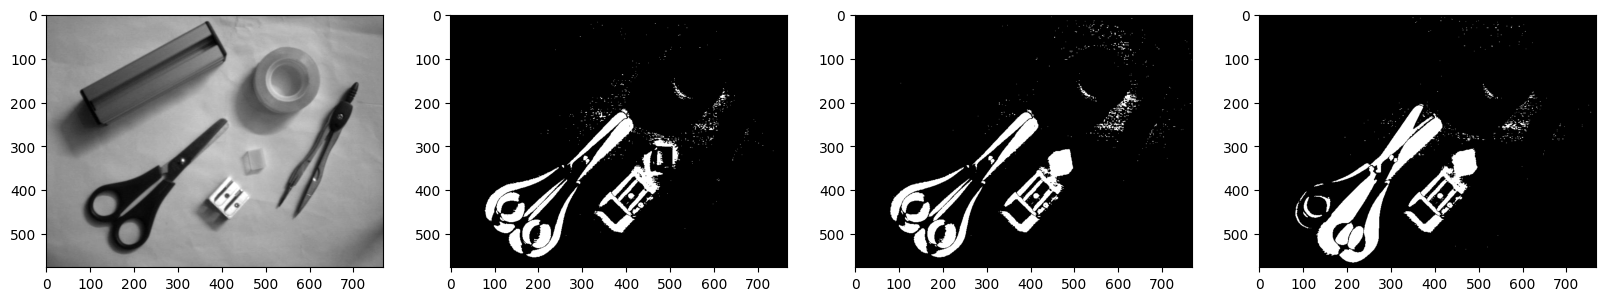

In [6]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

original_image = cv.imread("1.jpg", cv.IMREAD_GRAYSCALE)

_, img3 = cv.threshold(cv.absdiff(original_image, cv.imread("3.jpg", cv.IMREAD_GRAYSCALE)), 30, 255, cv.THRESH_BINARY)
_, img4 = cv.threshold(cv.absdiff(original_image, cv.imread("4.jpg", cv.IMREAD_GRAYSCALE)), 30, 255, cv.THRESH_BINARY)
_, img5 = cv.threshold(cv.absdiff(original_image, cv.imread("5.jpg", cv.IMREAD_GRAYSCALE)), 30, 255, cv.THRESH_BINARY)

images = [img3, img4, img5]
images = [cv.dilate(img, None, iterations=2) for img in images]
images = [original_image, img3, img4, img5]

plt.figure(figsize=(20, 10))
for (i, img) in enumerate(images):
    plt.subplot(1,4,i+1)
    plt.imshow(img, cmap='gray')


## Zadanie 2 - Detekcja zmian w obrazie (dzielenie obrazów)

Dzielienie jest kolejną opreacją, którą można wykorzystać w celu detekcji zmian w obrazie.  
  
Do wykonania tego zadania również proszę wykorzystać zdjęcia zamieszczone na e-portalu. Należy sprawdzić, czy przedmioty na zdjęciach 3.jpg, 4.jpg, 5.jpg uległy zmianie lub przesunięciu względem zdjecia 1.jpg z wkorzystaniem ilorazu zdjęć. Proszę pamięteć, że najlepszy efekt uzyskamu stosując dodatkowe operacje poprawiające efekt odejmowania: opercje morfologiczne, progowanie.

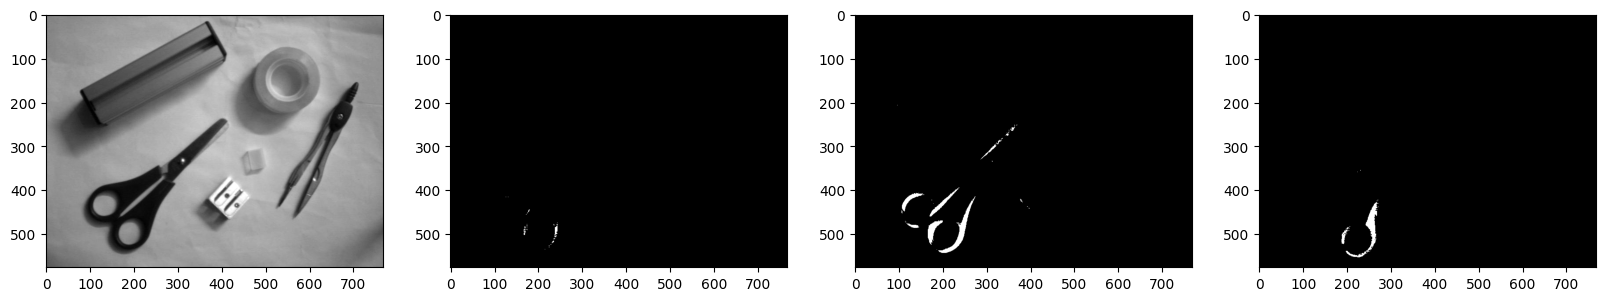

In [7]:
_, img3 = cv.threshold(cv.normalize(cv.divide(original_image, cv.imread("3.jpg", cv.IMREAD_GRAYSCALE)), None, 0, 255, cv.NORM_MINMAX).astype(np.uint8), 30, 255, cv.THRESH_BINARY)
_, img4 = cv.threshold(cv.normalize(cv.divide(original_image, cv.imread("4.jpg", cv.IMREAD_GRAYSCALE)), None, 0, 255, cv.NORM_MINMAX).astype(np.uint8), 30, 255, cv.THRESH_BINARY)
_, img5 = cv.threshold(cv.normalize(cv.divide(original_image, cv.imread("5.jpg", cv.IMREAD_GRAYSCALE)), None, 0, 255, cv.NORM_MINMAX).astype(np.uint8), 30, 255, cv.THRESH_BINARY)

kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))

images = [img3, img4, img5]
images = [cv.morphologyEx(img, cv.MORPH_OPEN, kernel)  for img in images]
images = [original_image, img3, img4, img5]

plt.figure(figsize=(20, 10))
for (i, img) in enumerate(images):
    plt.subplot(1,4,i+1)
    plt.imshow(img, cmap='gray')

## Zadanie 3 - detekcja ruchu

Techniki wykrywania zmian w obrazach możemy łatwo zastosować do stumienia wideo i zbudować detektor ruchu. W tym celu wczytujemy pierwszą ramkę wideo jako ramka referencyjna, a następnie wykonujemy operację odejmowania lub dzielenia ramki referencyjnej przez kolejne. Ogólny schemat można zapisać:


1.   wczytaj wideo 
2.   zamień ramkę na obraz monochromatyczny 
3. zastosuj filtr wygładzający (np. Gaussowaski)
4. dla kolejnej rami powtórz kroki 2 i 3 
5. Odejmij drugą ramkę od pierwszej 
6. zapisz drugą ramkę jako referencyjną 
7. do wynku odejmowania zastosuj operacje morfologiczne i progowanie
8. z obrazu wynikowego wylicz kontury
9. na podstawie konturów oblicz prostokąt okalający (bounding box)
10. nanieś prostokąt na oryginalne wideo.
11. wyświetl wynik


In [8]:
movie_path = './movie.mp4'
cap = cv.VideoCapture(movie_path)

ret, reference_frame = cap.read()

reference_frame = cv.cvtColor(reference_frame, cv.COLOR_BGR2GRAY)
reference_frame = cv.GaussianBlur(reference_frame, (21, 21), 0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    gray_frame = cv.GaussianBlur(gray_frame, (21, 21), 0)

    frame_delta = cv.absdiff(reference_frame, gray_frame)
    
    _, thresh = cv.threshold(frame_delta, 25, 255, cv.THRESH_BINARY)
    thresh = cv.dilate(thresh, None, iterations=2)
    
    contours, _ = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        if cv.contourArea(contour) < 500:
            continue
        (x, y, w, h) = cv.boundingRect(contour)
        cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv.imshow("frame", frame)
    reference_frame = gray_frame.copy()
    cv.waitKey(1)


cap.release()
cv.destroyAllWindows()

### Detekcja ruchu z kamery
 
Państwa zadaniem jest napisanie prostej aplikacji, która będzie przetwarzać obraz z kamery komputera i poinformuje użytkownika jeśli w obrazie z kamery zostanie wykrytu ruch. Należy wyświetlić stosowny komunikat w konsoli oraz na podglądzie z kamery. 

In [9]:
cap = cv.VideoCapture(0)

_, reference_frame = cap.read()

reference_frame = cv.cvtColor(reference_frame, cv.COLOR_BGR2GRAY)
reference_frame = cv.GaussianBlur(reference_frame, (21, 21), 0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    gray_frame = cv.GaussianBlur(gray_frame, (21, 21), 0)

    frame_delta = cv.absdiff(reference_frame, gray_frame)
    
    _, thresh = cv.threshold(frame_delta, 25, 255, cv.THRESH_BINARY)
    thresh = cv.dilate(thresh, None, iterations=2)
    
    contours, _ = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        if cv.contourArea(contour) < 500:
            continue
        (x, y, w, h) = cv.boundingRect(contour)
        cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv.imshow("frame", frame)
    
    reference_frame = gray_frame.copy()
    
    if cv.waitKey(1) & 0xFF == ord('q'):
        break


cap.release()
cv.destroyAllWindows()